In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flight-fare-prediction-mh/Data_Train.xlsx
/kaggle/input/flight-fare-prediction-mh/Sample_submission.xlsx
/kaggle/input/flight-fare-prediction-mh/Test_set.xlsx


<a id='tc'><h2>Section 1</h2></a>
****
<h1 style="background:#ffffe6;color:#ff4d4d"><center>Table of Contents and Loading the Data</center></h1>

* [Section 2](#eda) **EDA**
* [Section 3](#hcd) **Handling Categorical Data**
* [Section 4](#test) **Test Set**
* [Section 5](#fs) **Feature Selection**
* [Section 6](#fm) **Fitting Model**
* [Section 7](#ht) **Hyperparameter Tuning**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()


In [3]:
!pip install openpyxl

     |████████████████████████████████| 244 kB 925 kB/s eta 0:00:01


In [4]:
# this is an xlsx file
train=pd.read_excel(r'/kaggle/input/flight-fare-prediction-mh/Data_Train.xlsx',engine='openpyxl')
test=pd.read_excel(r'/kaggle/input/flight-fare-prediction-mh/Test_set.xlsx',engine='openpyxl')

In [5]:
train.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882


In [6]:
pd.set_option('display.max_columns', None)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [8]:
train.dropna(inplace=True)
train.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [9]:
train['Duration'].value_counts()

2h 50m     550
1h 30m     386
2h 45m     337
2h 55m     337
2h 35m     329
          ... 
27h 55m      1
5m           1
31h 50m      1
42h 45m      1
32h 20m      1
Name: Duration, Length: 368, dtype: int64

<a id='eda'><h2>Section 2</h2></a>
****
<h3 style="background:#e6ffee;color:#004d1a"><center>We have loaded our dataset and now we are all set for EDA (Exploratory Data Analysis)</center></h3>

[back to table of contents](#tc)

In [10]:
#converting the object data tyoe to date
#Year is constant throughout the data
train['day']=pd.to_datetime(train.Date_of_Journey, format = '%d/%m/%Y').dt.day
train['month']=pd.to_datetime(train.Date_of_Journey, format = '%d/%m/%Y').dt.month
train.drop(['Date_of_Journey'], axis=1, inplace=True)
#Year is constant throughout the data
train.head(2)

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,day,month
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5


In [11]:
#now lets move to Dep_Time column of the dataset

train['D_hour']=pd.to_datetime(train.Dep_Time).dt.hour
train['D_min']=pd.to_datetime(train.Dep_Time).dt.minute
train.drop(['Dep_Time'], axis=1, inplace=True)
train.head(2)

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,day,month,D_hour,D_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,13:15,7h 25m,2 stops,No info,7662,1,5,5,50


In [12]:
#In the column Arrival_Time, we are not obtaining month and day because that will be estimated during duration of flight
train['A_hour']=pd.to_datetime(train.Arrival_Time).dt.hour
train['A_min']=pd.to_datetime(train.Arrival_Time).dt.minute
train.drop(['Arrival_Time'], axis=1, inplace=True)
train.head(2)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,day,month,D_hour,D_min,A_hour,A_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15


In [13]:
#as we can see the format of duration is not same 

list_duration= list(train["Duration"])

for i in range(len(list_duration)):
    if len(list_duration[i].split()) !=2:
        if "h" in list_duration[i]:
            list_duration[i] = list_duration[i].strip() + " 0m"  
        else:
            list_duration[i] = "0h " + list_duration[i] 
            
hours = []
mins = []
for i in range(len(list_duration)):
    hours.append(int(list_duration[i].split(sep = "h")[0]))   
    mins.append(int(list_duration[i].split(sep = "m")[0].split()[-1])) 
train["Du_hours"] =hours
train["Du_mins"] =mins

train.drop(["Duration"], axis = 1, inplace = True)

In [14]:
train.head(2)

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,day,month,D_hour,D_min,A_hour,A_min,Du_hours,Du_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25


<a id='hcd'><h2>Section 3</h2></a>
****
<h3 style="background:#e6ffff;color:#004d4d"><center>Handling Categorical Data</center></h3>

[back to table of contents](#tc)

In [15]:
train['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

<AxesSubplot:xlabel='Airline', ylabel='Price'>

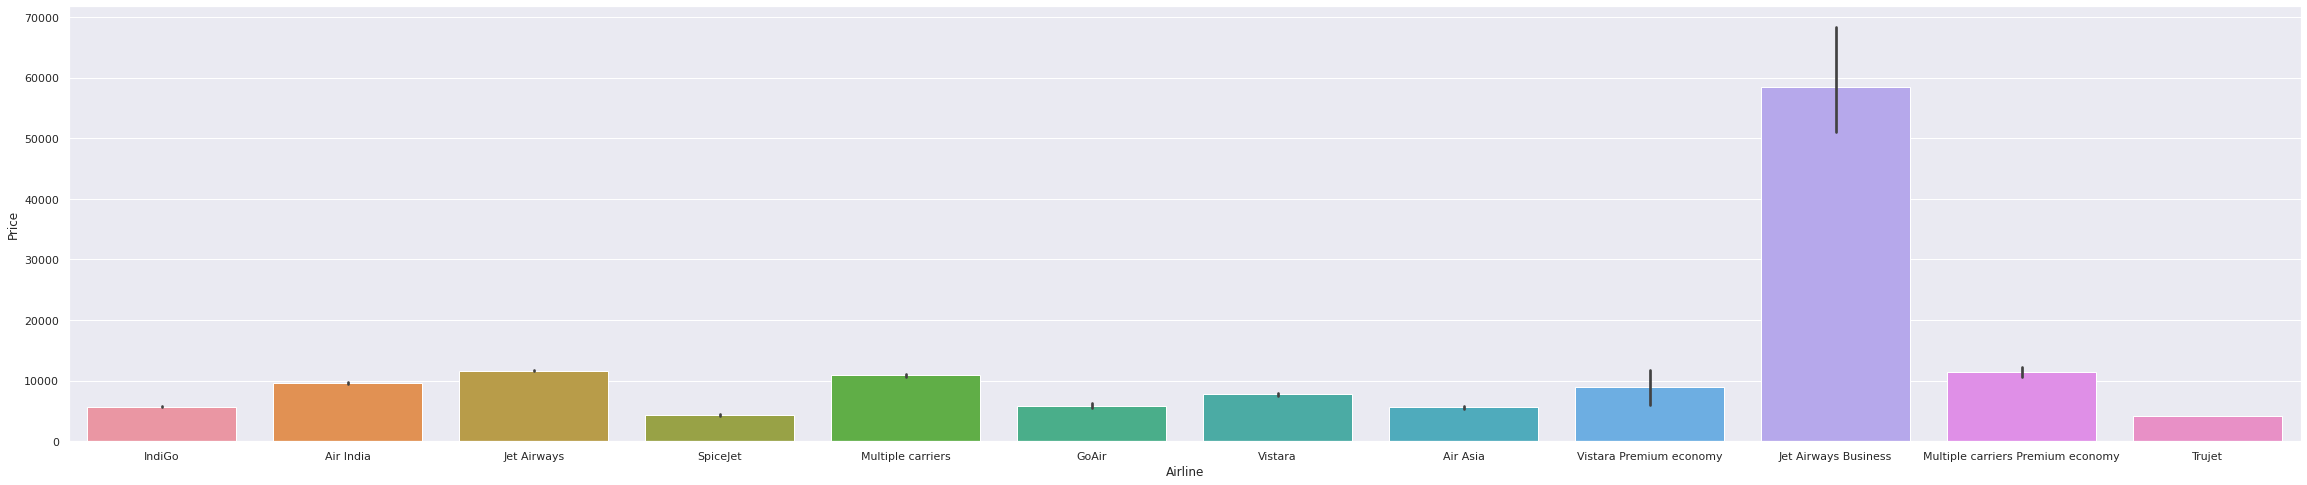

In [16]:
dims = (40, 8) 
#change size accordingly, here I have used x axis as 40 to avoid overlapping of lables
fig, ax = plt.subplots(figsize= dims)
sns.barplot(data=train, x='Airline', y='Price')

In [17]:
#Here Airline is Nominal Categorical data, so we perform OneHotEncoding

Airline = train[["Airline"]]
Airline = pd.get_dummies(Airline, drop_first= True)
Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64


,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


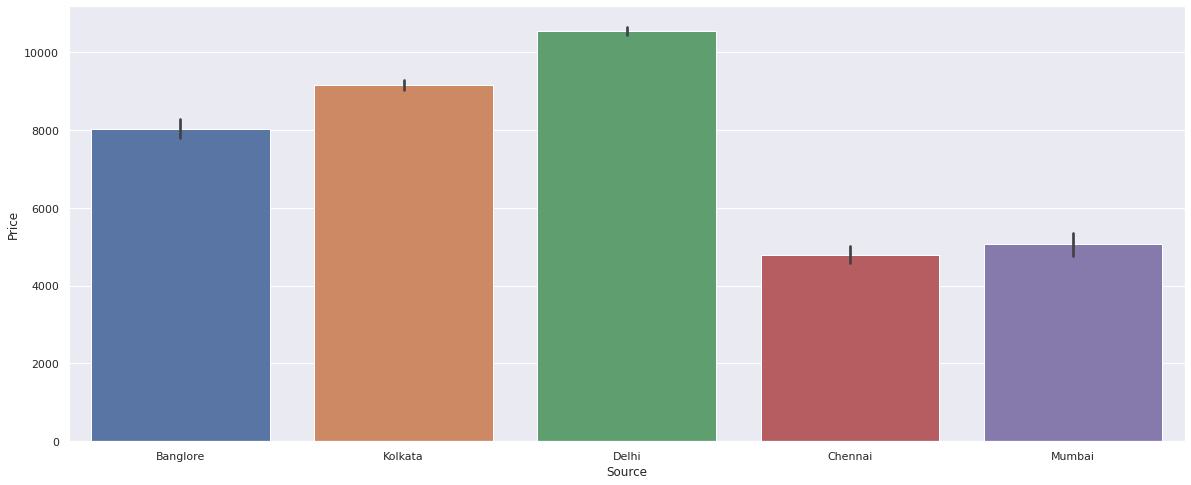

In [18]:
#Source

print(train['Source'].value_counts())

dims = (20, 8) 
#change size accordingly, here i have used x axis as 40 to avoid overlapping of lables
fig, ax = plt.subplots(figsize= dims)
sns.barplot(data=train, x='Source', y='Price')

#for nominal category
Source = train[["Source"]]
Source = pd.get_dummies(Source, drop_first= True)
Source.head()

In [19]:
#Destination

#destination will be same as source
print(train['Destination'].value_counts())
Destination = train[["Destination"]]
Destination = pd.get_dummies(Destination, drop_first=True)
Destination.head()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64


,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [20]:
train.head(2)
#here we can see that Route is connected to Total_stops and the column Additional_info is almost empty

train.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [21]:
#Total_Stops

print(train["Total_Stops"].value_counts())

#It's a case of Ordinal Categorical data type so we will implememnt LableEncoder
train.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)
train.head(3)

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64


,Airline,Source,Destination,Total_Stops,Price,day,month,D_hour,D_min,A_hour,A_min,Du_hours,Du_mins
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0


In [22]:
data_train = pd.concat([train, Airline, Source, Destination], axis = 1)
data_train.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [23]:
print(data_train.shape)
data_train.head(3)

(10682, 30)


,Total_Stops,Price,day,month,D_hour,D_min,A_hour,A_min,Du_hours,Du_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


<a id='test'><h2>Section 4</h2></a>
****
<h3 style="background:#fff9e6;color:#4d3900"><center>Test Set (Preprocessing)</center></h3>

[back to table of contents](#tc)

In [24]:
test.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included


In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB


In [26]:
test.dropna(inplace = True)
print(test.isnull().sum())

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64


* **While making changes in train data, we can use for loop for datasets: where datasets= [train,test]**
* **But to avoid confusion I have separately edited both train and test**

<h3 style= "color:#004d1a">EDA (Exploratory Data Analysis)</h3>

In [27]:
#Date_of_Journey
test['day']=pd.to_datetime(test.Date_of_Journey, format = '%d/%m/%Y').dt.day
test['month']=pd.to_datetime(test.Date_of_Journey, format = '%d/%m/%Y').dt.month
test.drop(['Date_of_Journey'], axis=1, inplace=True)
#Year is constant throughout the data


test['D_hour']=pd.to_datetime(test.Dep_Time).dt.hour
test['D_min']=pd.to_datetime(test.Dep_Time).dt.minute
test.drop(['Dep_Time'], axis=1, inplace=True)

test['A_hour']=pd.to_datetime(test.Arrival_Time).dt.hour
test['A_min']=pd.to_datetime(test.Arrival_Time).dt.minute
test.drop(['Arrival_Time'], axis=1, inplace=True)

list_duration= list(test["Duration"])

for i in range(len(list_duration)):
    if len(list_duration[i].split()) !=2:
        if "h" in list_duration[i]:
            list_duration[i] = list_duration[i].strip() + " 0m"  
        else:
            list_duration[i] = "0h " + list_duration[i] 
            
hours = []
mins = []
for i in range(len(list_duration)):
    hours.append(int(list_duration[i].split(sep = "h")[0]))   
    mins.append(int(list_duration[i].split(sep = "m")[0].split()[-1])) 
test["Du_hours"] =hours
test["Du_mins"] =mins

test.drop(["Duration"], axis = 1, inplace = True)

<h3 style= "color:#004d4d">Handling Categorical Data</h3>

In [28]:
Airline = test[["Airline"]]
Airline = pd.get_dummies(Airline, drop_first= True)

Source = test[["Source"]]
Source = pd.get_dummies(Source, drop_first= True)

Destination = test[["Destination"]]
Destination = pd.get_dummies(Destination, drop_first=True)

test.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

test.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

data_test = pd.concat([train, Airline, Source, Destination], axis = 1)
data_test.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [29]:
data_test.head(2)

,Total_Stops,Price,day,month,D_hour,D_min,A_hour,A_min,Du_hours,Du_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,2,50,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,7662,1,5,5,50,13,15,7,25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id='fs'><h2>Section 5</h2></a>
****
<h3 style="background:#ffe6ff;color:#4d004d"><center>Feature Selection</center></h3>

[back to table of contents](#tc)

In [30]:
data_train.columns

Index(['Total_Stops', 'Price', 'day', 'month', 'D_hour', 'D_min', 'A_hour',
       'A_min', 'Du_hours', 'Du_mins', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi'],
      dtype='object')

for beginners- [dataframe.loc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html),
[dataframe.iloc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html#pandas.DataFrame.iloc)

In [31]:
X = data_train.loc[:,['Total_Stops','day', 'month', 'D_hour', 'D_min', 'A_hour',
       'A_min', 'Du_hours', 'Du_mins', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi']]
X.head(3)

#try obtaining X by dropping the 'Price' column 

,Total_Stops,day,month,D_hour,D_min,A_hour,A_min,Du_hours,Du_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,24,3,22,20,1,10,2,50,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,1,5,5,50,13,15,7,25,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,9,6,9,25,4,25,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [32]:
y = data_train.iloc[:, 1]
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

In [33]:
train.corr()
#it's difficult to read the table so we can implement heatmap which will be visual display for the exact same table of correlational values

,Total_Stops,Price,day,month,D_hour,D_min,A_hour,A_min,Du_hours,Du_mins
Total_Stops,1.000000,0.603897,-0.009451,0.054383,-0.061476,-0.002618,0.038140,-0.106940,0.739916,-0.136706
Price,0.603897,1.000000,-0.153774,-0.103643,0.006799,-0.024458,0.024244,-0.086155,0.508778,-0.124855
day,-0.009451,-0.153774,1.000000,-0.038359,0.002170,-0.008170,-0.003245,-0.017510,-0.022059,-0.008940
month,0.054383,-0.103643,-0.038359,1.000000,0.039127,-0.059267,-0.003927,-0.100626,0.016141,-0.040897
D_hour,-0.061476,0.006799,0.002170,0.039127,1.000000,-0.024745,0.005180,0.067911,0.002869,-0.023707
D_min,-0.002618,-0.024458,-0.008170,-0.059267,-0.024745,1.000000,0.043122,-0.017597,-0.022104,0.092485
A_hour,0.038140,0.024244,-0.003245,-0.003927,0.005180,0.043122,1.000000,-0.154363,0.055276,-0.118309
A_min,-0.106940,-0.086155,-0.017510,-0.100626,0.067911,-0.017597,-0.154363,1.000000,-0.074450,0.151628
Du_hours,0.739916,0.508778,-0.022059,0.016141,0.002869,-0.022104,0.055276,-0.074450,1.000000,-0.126468
Du_mins,-0.136706,-0.124855,-0.008940,-0.040897,-0.023707,0.092485,-0.118309,0.151628,-0.126468,1.000000


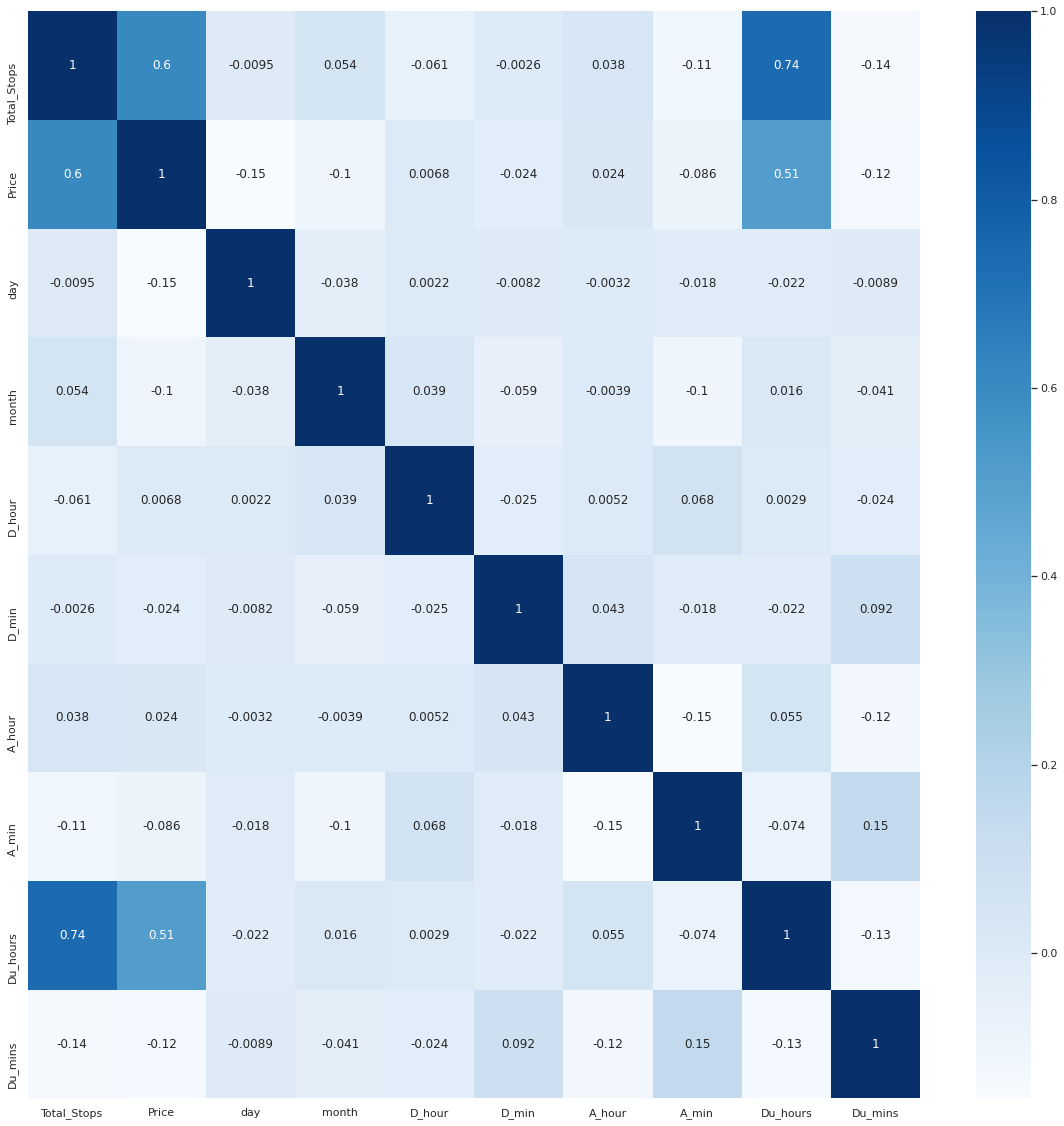

In [34]:
plt.figure(figsize = (20,20))
sns.heatmap(train.corr(), annot = True, cmap = "Blues")
plt.show()

* ***ExtraTreesRegressor***
This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.*

In [35]:
from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

In [36]:
print(selection.feature_importances_)

[2.05201025e-01 1.44072988e-01 5.35752502e-02 2.33713552e-02
 2.10818701e-02 2.81402969e-02 1.88913638e-02 1.47793286e-01
 1.76668571e-02 9.26002946e-03 2.07738169e-03 1.66042723e-02
 1.36540927e-01 6.71378767e-02 1.85440390e-02 8.83632693e-04
 2.84358329e-03 9.34835113e-05 4.91014318e-03 9.27718600e-05
 4.04594184e-04 1.12215427e-02 3.13424660e-03 6.81544733e-03
 9.91038781e-03 1.69749585e-02 7.49426211e-03 5.35491495e-04
 2.47266359e-02]


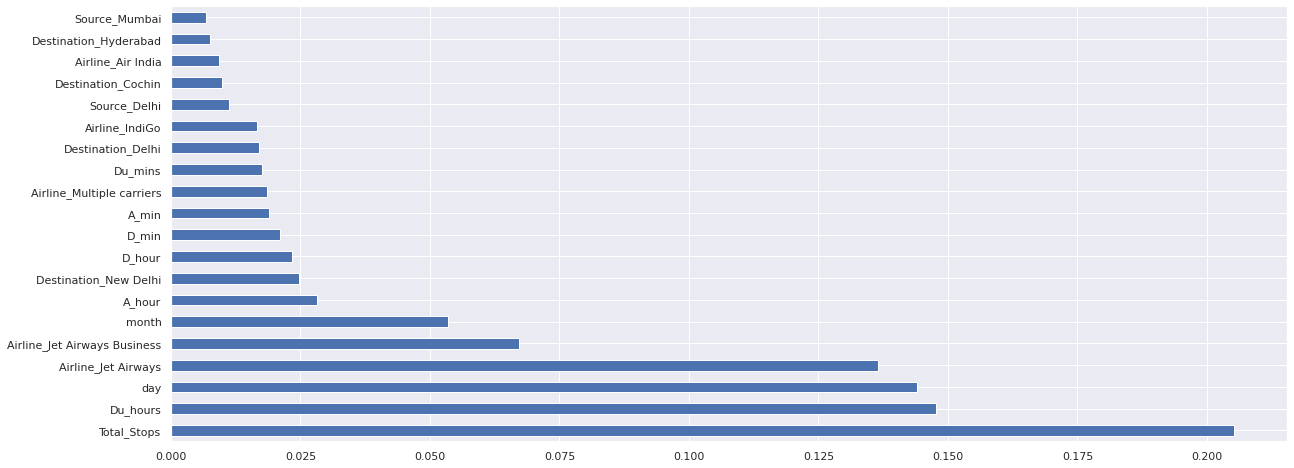

In [37]:
#plot graph of feature importances for better visualization
plt.figure(figsize = (20,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

<a id='fm'><h2>Section 6</h2></a>
****

<h3 style="background:#ffbf80;color:#663300"><center>Fitting Model</center></h3>

![Random Forest](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/rfc_vs_dt1.png)

Image by Analystics Vidhya*


[back to table of contents](#tc)

* Split dataset into train and test set in order to prediction w.r.t X_test
* Import model
* Fit the data
* Predict w.r.t X_test
* In regression check RSME Score
* Plot graph

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 32)
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [40]:
y_pred = model.predict(X_test)

In [41]:
model.score(X_train, y_train)

0.9540283109152701

In [42]:
model.score(X_test, y_test)

0.8200044138229358

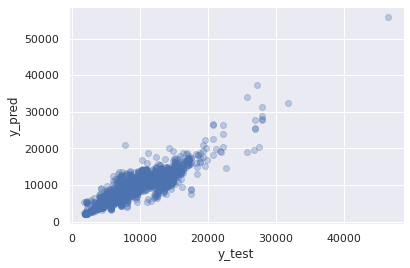

In [43]:
plt.scatter(y_test, y_pred, alpha = 0.3)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [44]:
#RMSE
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

# RMSE/(max(DV)-min(DV))
print(rmse/(max(y)-min(y)))

metrics.r2_score(y_test, y_pred)

0.023939260695405435


0.8200044138229358

<a id='ht'><h2>Section 7</h2></a>
****

<h3 style="background:#e6ffe6;color:#003300"><center>Hyperparameter Tuning</center></h3>

* RandomizedSearchCV 
* Assign hyperparameters in form of dictionery
* Fit the model
* Check best paramters and best score

[back to table of contents](#tc)

In [45]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

Create Random Grid

In [46]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [47]:
random = RandomizedSearchCV(estimator = model, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [48]:
random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   4.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   6.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   6.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [49]:
random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [50]:
final_prediction = random.predict(X_test)

In [51]:
#please upvote to support